## Positive Dimensional Local minimizers

In [11]:
# Globtim Notebook Setup - Universal Header Cell
# This cell automatically detects your environment and sets up the appropriate configuration
# No editing required - works from any location in the project

include(joinpath(dirname(Base.find_package("Globtim")), "..", ".globtim", "notebook_setup.jl"))

Environment detected: local
Setting up local development environment...


  Activating 

Loading CairoMakie...


project at `~/globtim/environments/local`


CairoMakie activated for high-quality plots
GLMakie available for interactive plots
Loading Globtim from main project...
Globtim loaded successfully!
Ready for local development!
Available: Full plotting, interactive development tools
Switch plotting: GLMakie.activate!() for interactive plots


In [12]:
# Constants and Parameters
const n, a, b = 2, 1, 1
f(x) = (x[1]^2+ x[2]^2 -1)^2 # Objective function

f (generic function with 1 method)

In [13]:
d = 8 # Initial Degree 
SMPL = 100 # Number of samples
center = [0.0, 0.0]
TR = test_input(f,
                dim=n,
                center=[0.0, 0.0],
                GN=SMPL,
                sample_range=[1.2, 1.5]
                )
pol_cheb = Constructor(TR, d, basis=:chebyshev, precision= AdaptivePrecision)
pol_lege = Constructor(TR, d, basis=:legendre);


current L2-norm: 9.132329395398915e-15
current L2-norm: 5.951117605996182e-15


In [14]:
@polyvar(x[1:n]) # Define polynomial ring 
real_pts_cheb = solve_polynomial_system(
    x, n, d, pol_cheb.coeffs;
    basis=pol_cheb.basis,
    precision=pol_cheb.precision,
    normalized=false,
    power_of_two_denom=pol_cheb.power_of_two_denom
)

real_pts_lege = solve_polynomial_system(
    x, n, d, pol_lege.coeffs;
    basis=pol_lege.basis,
    precision=pol_lege.precision,
    normalized=true)

df_cheb = process_crit_pts(real_pts_cheb, f, TR)
df_lege = process_crit_pts(real_pts_lege, f, TR)

3×3 DataFrame
 Row │ x1            x2            z           
     │ Float64       Float64       Float64     
─────┼─────────────────────────────────────────
   1 │  0.624695      0.780869     5.96576e-30
   2 │ -7.24513e-17  -1.47261e-15  1.0
   3 │ -0.624695     -0.780869     3.99361e-30

In [15]:
using Optim
df_cheb, df_min_cheb = analyze_critical_points(f, df_cheb, TR, tol_dist=0.001)
df_lege, df_min_lege = analyze_critical_points(f, df_lege, TR, tol_dist=0.001);

Processing point 1 of 3
Optimization has converged within bounds: ✓
Processing point 2 of 3
Optimization has converged within bounds: ✓
Processing point 3 of 3
Optimization has converged within bounds: ✓

=== Computing Enhanced Statistics ===
Computing spatial regions...
Clustering function values...
Computing nearest neighbor distances...
Computing gradient norms at critical points...
Analyzing basins of attraction...
Computing gradient norms at minimizers...
Enhanced statistics computed successfully!
New df columns: region_id, function_value_cluster, nearest_neighbor_dist, gradient_norm
New df_min columns: basin_points, average_convergence_steps, region_coverage_count, gradient_norm_at_min

=== Computing Complete Hessian Analysis ===
Computing Hessian matrices...
Computing all eigenvalues...
Classifying critical points...
Extracting critical eigenvalues...
Computing Hessian norms...
Computing eigenvalue statistics...
Computing Hessian analysis for minimizers...
Hessian analysis compl

In [16]:
using CairoMakie
CairoMakie.activate!()

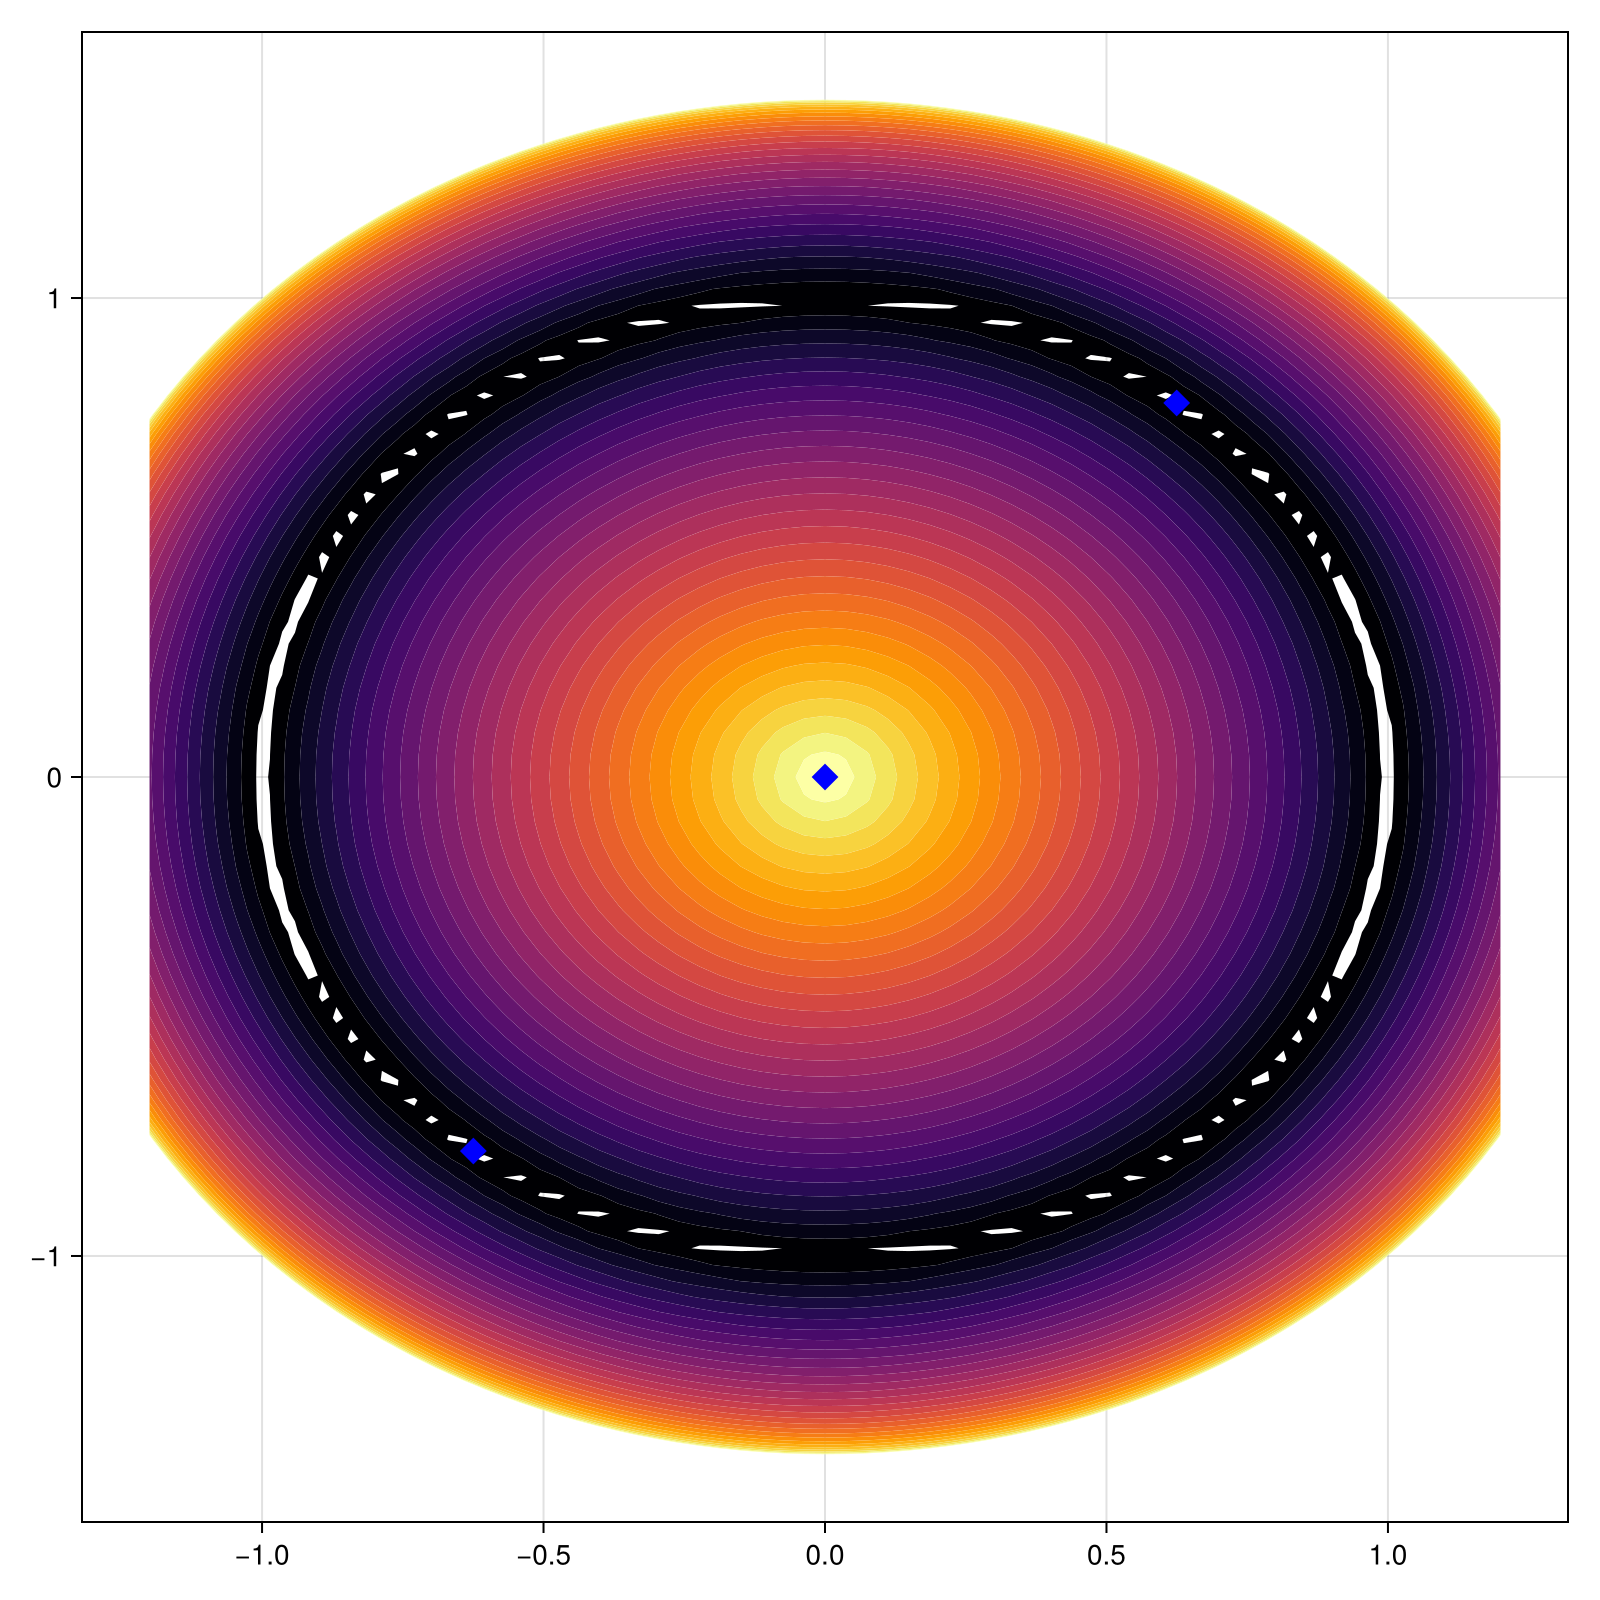

In [17]:
fig_1 = cairo_plot_polyapprox_levelset(pol_cheb, TR, df_cheb, df_min_cheb, chebyshev_levels=true, figure_size=(800, 800))

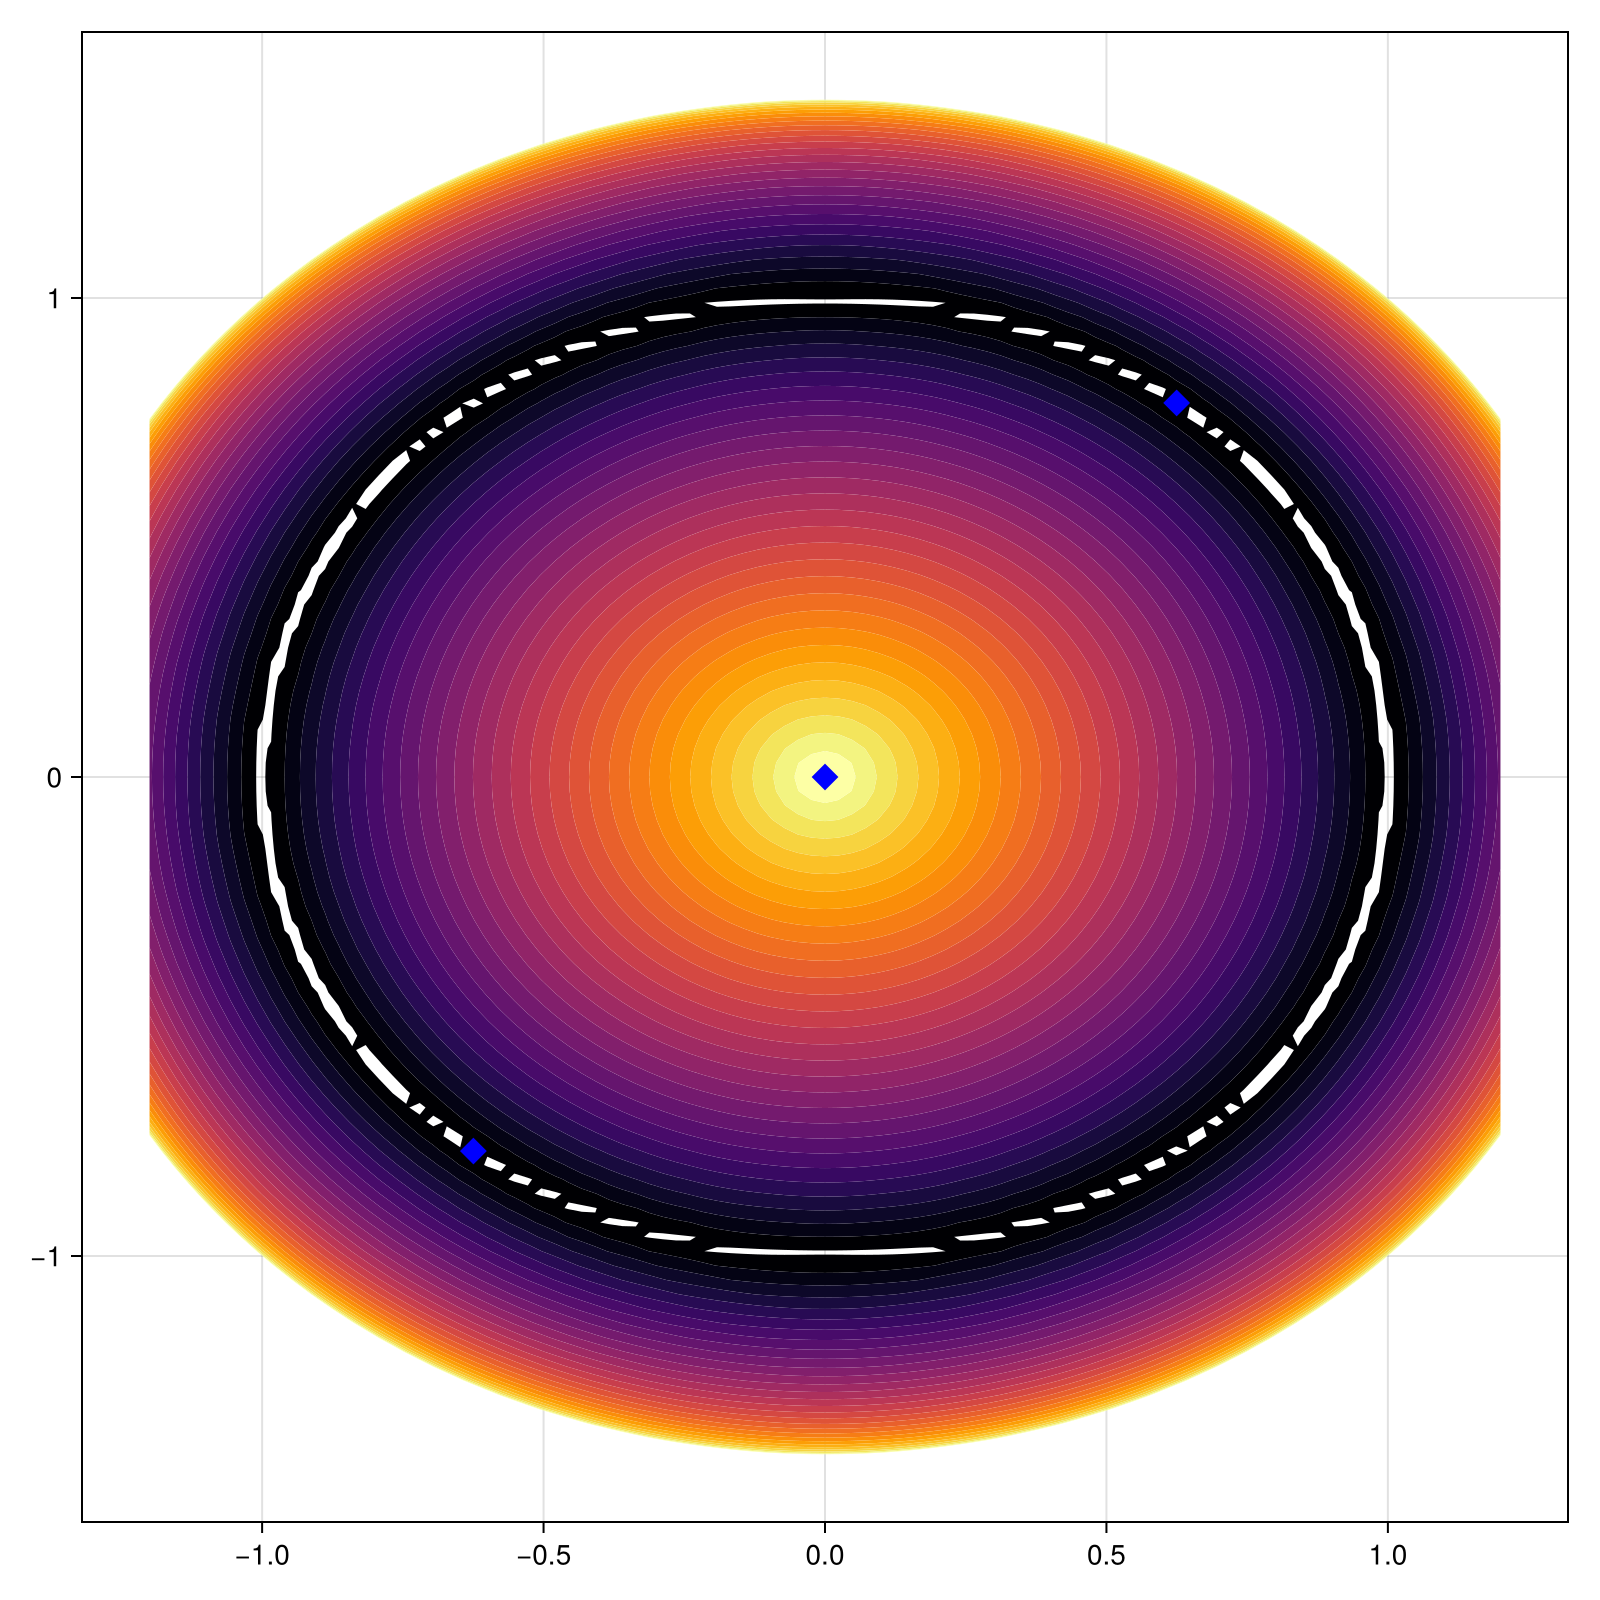

In [18]:
fig_2 = cairo_plot_polyapprox_levelset(pol_lege, TR, df_lege, df_min_lege, chebyshev_levels=true, figure_size = (800, 800))

In [19]:
# Commented out save command
# save("Deuflhard_w_22.pdf", fig_1)

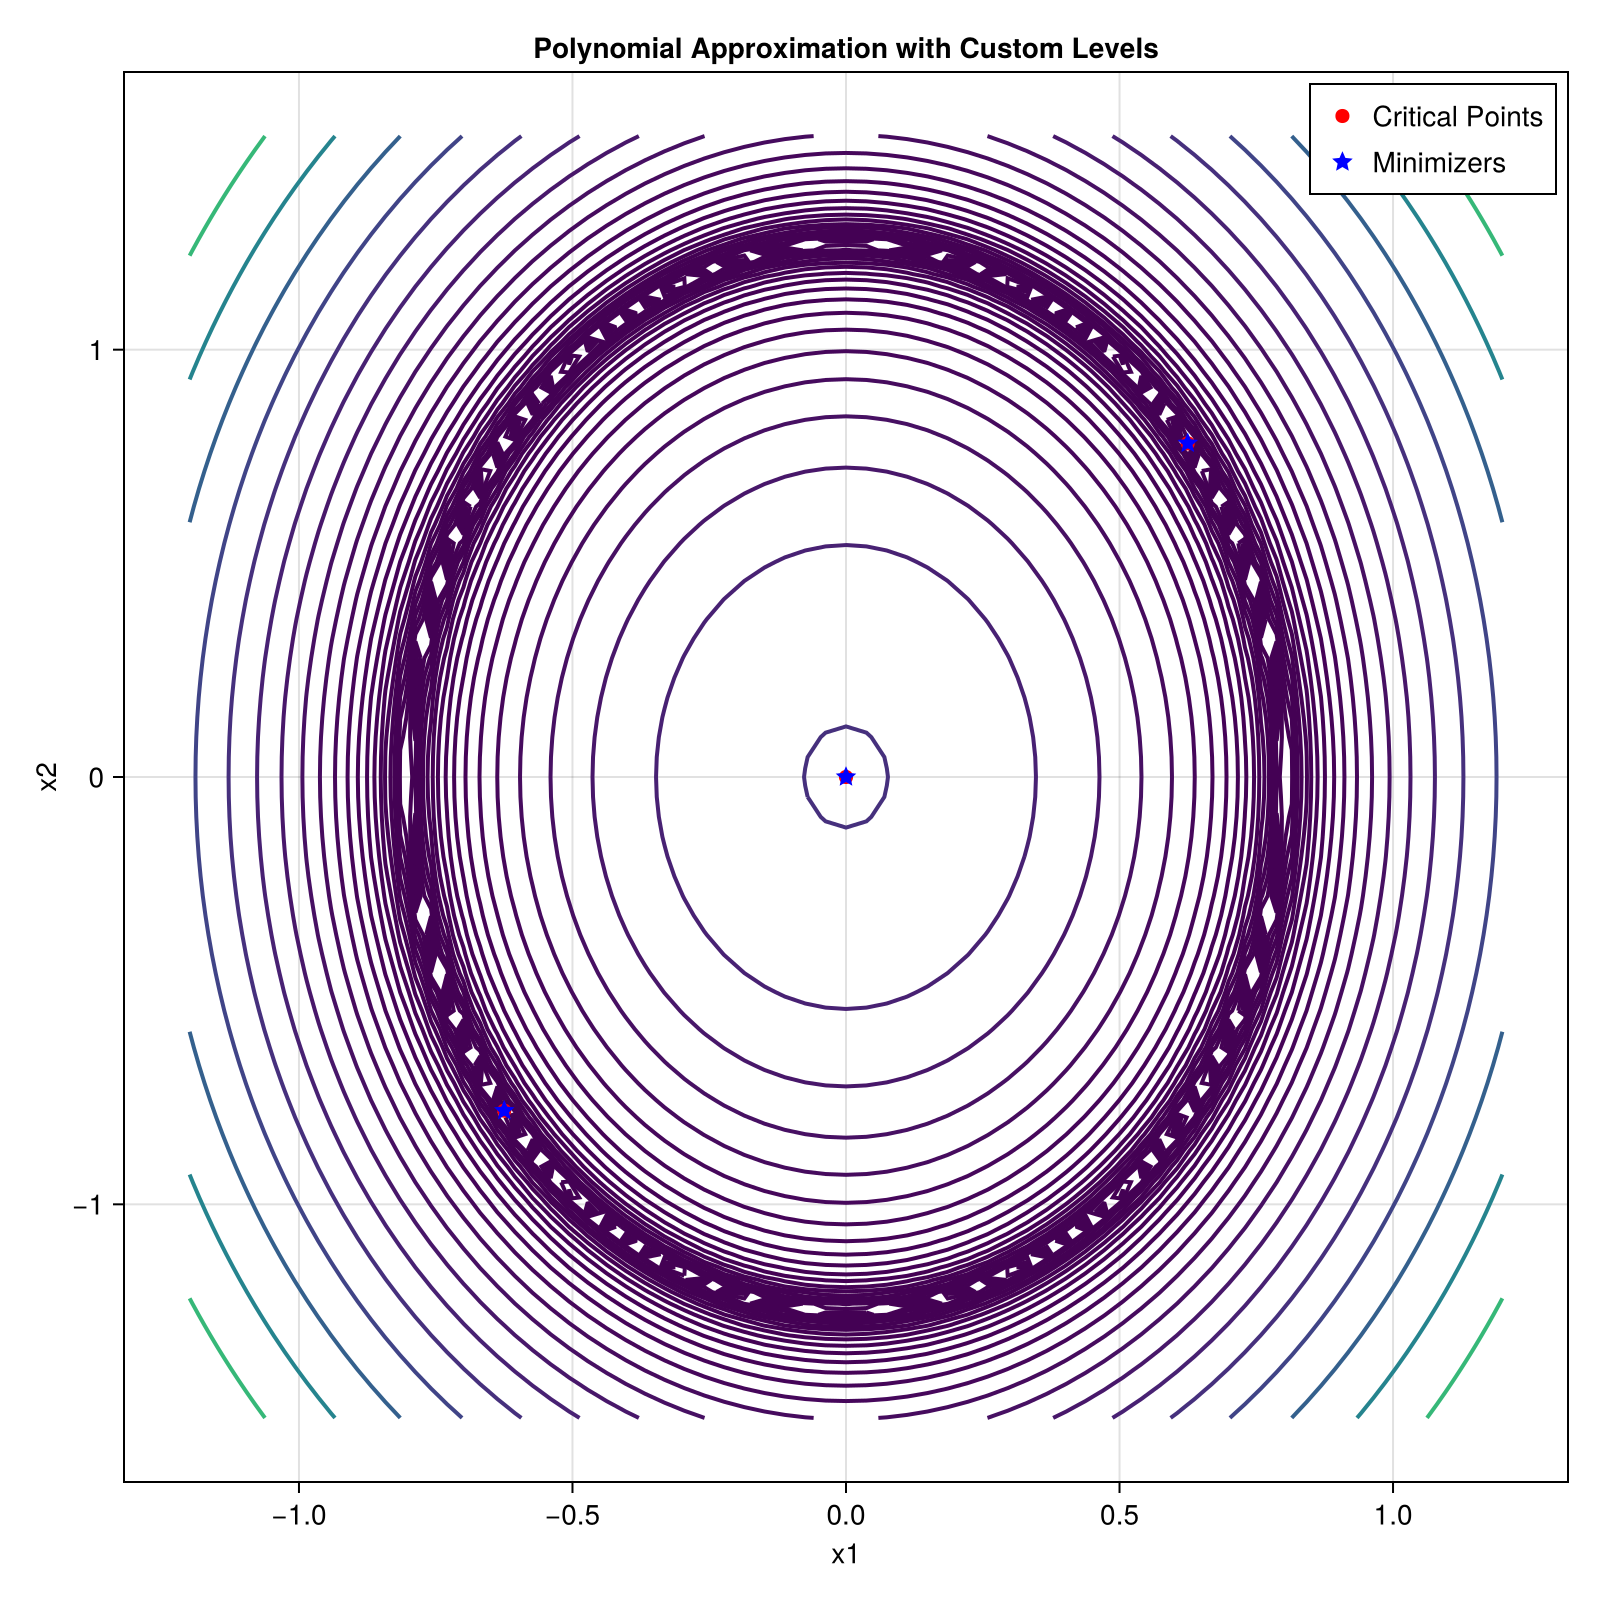

In [25]:
using StaticArrays
Lambda = SupportGen(n, pol_cheb.degree)
V = Globtim.lambda_vandermonde(Lambda, pol_cheb.grid, basis=pol_cheb.basis)
# Evaluate polynomial at grid points: polynomial_values = V * coefficients  
polynomial_values = V * pol_cheb.coeffs

# Now use the existing plotting infrastructure but replace pol_cheb.z with polynomial_values
coords = transform_coordinates(pol_cheb.scale_factor, pol_cheb.grid, TR.center)

# Create contour plot
x_unique = sort(unique(coords[:, 1]))
y_unique = sort(unique(coords[:, 2]))
Z = fill(NaN, (length(y_unique), length(x_unique)))

for (idx, (x, y, z)) in enumerate(zip(coords[:, 1], coords[:, 2], polynomial_values))
    i = findfirst(≈(y), y_unique)
    j = findfirst(≈(x), x_unique)
    if !isnothing(i) && !isnothing(j)
        Z[i, j] = z
    end
end

# Find the minimum value in your polynomial
min_val = minimum(polynomial_values)
max_val = maximum(polynomial_values)

# Create logarithmically spaced levels close to minimum
if min_val > 0
    # If minimum is positive, use log spacing from min to max
    levels = exp.(range(log(min_val), log(max_val), length=40))
else
    # If minimum is near zero or negative, focus levels near zero
    abs_min = abs(min_val)
    levels_pos = exp.(range(log(1e-10), log(max_val), length=15))
    levels_neg = -exp.(range(log(1e-10), log(abs_min), length=5))
    levels = sort([levels_neg; levels_pos])
end

# Create figure and axis
fig = Figure(size=(800, 800))
ax = Axis(fig[1, 1], xlabel="x1", ylabel="x2", title="Polynomial Approximation with Custom Levels")

# Plot with custom levels
contour!(ax, x_unique, y_unique, Z, levels=levels, linewidth=2)
scatter!(ax, df_cheb.x1, df_cheb.x2, color=:red, markersize=10, label="Critical Points")
scatter!(ax, df_min_cheb.x1, df_min_cheb.x2, color=:blue, markersize=12, marker=:star5, label="Minimizers")
axislegend(ax)
fig